# **Classifying images into Night, Portrait, and Landscape Mode using Image Analysis and K-Nearest Neighbor (KNN) Classifier**
This python script was used for lassifying images into 3 different camera modes, mainly: Night Mode, Landscape Mode, and Portrait Mode.

First, we import the necessary packages that will be used in this script. This python script mainly uses OpenCV, an open source library commonly used for Computer Vision. We also used the sklearn library to implement the KNN Classifier, an instance-based machine learning algorithm that uses proximity of values to make classification or predictions about a certain data point. 

In [1]:
#import necessary packages
import cv2 as cv
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image

Here, we now created a function that will be used to compute for the Skin Percentage, Darkness Percentage, and amount of blur that will be used for classifying the images into the different modes.

In [3]:
#Creating the function for classifying Camera Modes
def cameraMode(file):
  img = cv.imread(file, 1)
    
  #Camera Mode: Portrait
  #Compute for the presence of skin in images
  
  #converting color mode from rgb to hsv
  conHSV = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  
  #Calculations for Skin Color %age
  
  #Setting up tresholds
  lowerTresh = np.array([0, 48, 80], dtype="uint8")
  upperTresh = np.array([20, 255, 255], dtype="uint8")
  
  #apply mask if inside treshold
  skinMask = cv.inRange(conHSV, lowerTresh, upperTresh)
  
  #reduce noise and false positives by applying erosion and dilation
  kernel = np.ones((5, 5), np.uint8)
  skinMask = cv.erode(skinMask, kernel, iterations=1)
  skinMask = cv.dilate(skinMask, kernel, iterations=1)
  
  #apply also small amount of gaussian blur
  skinMask = cv.GaussianBlur(skinMask, (3, 3), 0)
  
  # compute the amount of skin present in the image
  skin_percentage = (cv.countNonZero(skinMask) / (skinMask.shape[0] * skinMask.shape[1]))*100
  
  #Camera Mode: Night and Landscape
  # This code uses the mean value of the pixels in the image as the threshold for determining whether a pixel is "dark" or not. This is a more flexible and adaptive approach than using a hard-coded threshold value, as the mean value will be different for each image. 
  
  # Read in the image file and convert it to grayscale
  img = cv.imread(file, 0)

  # Get the dimensions of the image
  height, width = img.shape

  # Calculate the mean pixel value of the image
  mean_val = np.mean(img)

  # Count the number of pixels in the image that are less than the mean value
  dark_pixels = np.sum(img < mean_val)

  # Calculate the percentage of dark pixels in the image
  dark_percent = (dark_pixels * 100.0) / (height * width)
  
  # Calculating amount of blur
  img_height, img_width = img.shape[:2]
  roi_left = img[0:img_height, 0:int(img_width/3)]
  roi_right = img[0:img_height, 2*int(img_width/3):img_width]
  bl_left = cv.Laplacian(roi_left, cv.CV_64F).var()
  br_right = cv.Laplacian(roi_right, cv.CV_64F).var()
  blur_amount = min(bl_left, br_right)


  return [round(skin_percentage, 2), round(dark_percent, 2), round(blur_amount, 4)]

Here, we created the training data set that will be used for the KNN model. The skin percentage, darkness percentage, and amount of blur for the images where computed using the cameraMode function and the results where appended to the dark_list array. These data were also labeled as night, landscape, and portrait. The indices in the dark_list array corresponds to the indices in the label array.

In [4]:
dark_list = []
label = []

# Creating a data set to train the Model
for k in range(1, 31):
    dark_per = cameraMode("training data/train-nt-"+str(k)+".jpg")
    dark_list.append(dark_per)
    dark_per = cameraMode("training data/train-ls-"+str(k)+".jpg")
    dark_list.append(dark_per)
    dark_per = cameraMode("training data/train-pt-"+str(k)+".jpg")
    dark_list.append(dark_per)
    label.append("night")
    label.append("landscape")
    label.append("portrait")

print(dark_list)
print(label)

[[0.07, 94.78, 56.225], [24.7, 2.73, 2557.8014], [16.12, 22.27, 38.6397], [2.32, 87.8, 1062.1061], [0.0, 1.9, 494.6062], [43.2, 3.17, 47.9791], [2.35, 84.24, 29.7372], [8.09, 6.89, 1436.7747], [39.03, 15.42, 52.9707], [2.31, 88.5, 257.7584], [21.96, 9.61, 5506.7533], [41.02, 11.3, 35.3471], [0.18, 94.12, 224.3315], [4.22, 11.34, 1873.9709], [51.51, 12.09, 38.8495], [29.32, 36.36, 43.8932], [0.49, 29.18, 84.2637], [11.76, 25.26, 41.0684], [6.58, 81.07, 534.0201], [2.1, 4.69, 186.9369], [46.43, 1.51, 42.9235], [3.17, 75.13, 791.8752], [0.0, 9.33, 85.9394], [4.07, 29.62, 4.2181], [0.86, 82.89, 1252.5481], [0.0, 2.65, 977.5948], [26.47, 11.53, 2.3918], [2.32, 87.58, 483.8969], [0.27, 22.06, 72.8366], [28.13, 11.36, 37.2138], [0.0, 85.11, 742.2631], [7.08, 7.04, 443.7119], [31.76, 6.64, 24.9161], [1.46, 57.79, 838.8273], [3.54, 12.59, 131.2137], [23.32, 9.5, 248.7858], [1.39, 94.11, 34.6965], [3.9, 0.3, 114.9812], [18.84, 10.09, 15.0798], [0.01, 76.86, 155.8306], [0.13, 51.94, 369.5824], [2

After creating the training data set, we now create an instance of the KNN Classifier. Then, we plugged the training data set into the Model to allow it to "learn" and classify the images into camera modes. After training the model, it was then saved as a file.

In [5]:
# Creating an instance of KNN Classifier
neigh = KNeighborsClassifier(n_neighbors=1)

# Training the Model
neigh.fit(dark_list, label)

# Save model
filename = 'finalized_model.sav'
pickle.dump(neigh, open(filename, 'wb'))

Before the testing procedures, the model should first be loaded.

In [6]:
filename = 'finalized_model.sav'
neigh = pickle.load(open(filename, 'rb'))

Then, we plug images to the model and allow it to classify the images.

['night']
[3.59, 91.12, 6.6177]


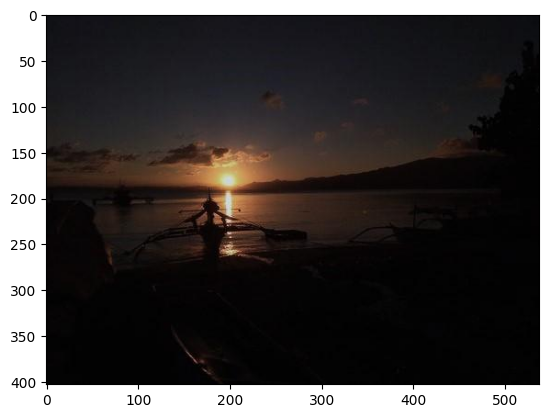

In [7]:
#Night Images
test_img1 = "test data/night/test-nt-1.jpg"
img = cv.imread(test_img1)
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

imgplot = plt.imshow(img_RGB)
print(neigh.predict([cameraMode(test_img1)]))
print(cameraMode(test_img1))


['landscape']
[2.36, 8.98, 1588.8397]


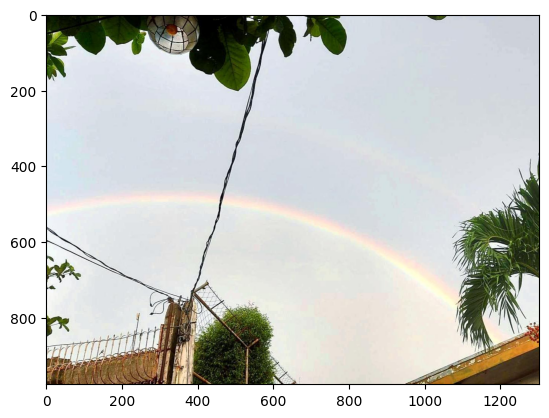

In [8]:
#Landscape
test_img2 = "test data/landscape/test-ls-18.jpg"
img = cv.imread(test_img2)
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

imgplot = plt.imshow(img_RGB)
print(neigh.predict([cameraMode(test_img2)]))
print(cameraMode(test_img2))


['portrait']
[23.98, 28.99, 6.5941]


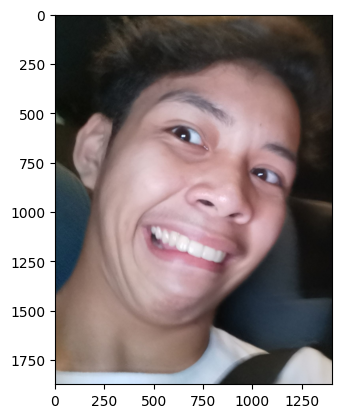

In [9]:
#Portrait
test_img3 = "test data/portrait/test-pt-20.jpg"
img = cv.imread(test_img3)
img_RGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)

imgplot = plt.imshow(img_RGB)
print(neigh.predict([cameraMode(test_img3)]))
print(cameraMode(test_img3))